# Bayes–MNIST: Naïve Bayes vs Neural Network

This notebook accompanies the subsection *“From Bayes’ Rule to Naïve Bayes and Neural Networks”*.

We use the MNIST handwritten digits dataset to compare:

1. A **Naïve Bayes classifier**, which assumes conditional independence of pixel features given the class;
2. A small **neural network classifier**, trained with cross-entropy;
3. **Evaluation tools** (confusion matrices and calibration curves) that will reappear later when we discuss KL divergence and cross-entropy.

All figures are saved into the `figs/` directory so they can be included in the book.


In [1]:
# Imports
import os
os.makedirs("figs", exist_ok=True)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1. Loading and Preprocessing MNIST

We work with the standard MNIST dataset of handwritten digits \(0,\dots,9\).

Two parallel representations are used:

1. **For Naïve Bayes** we use **binarized pixels** (on/off), suitable for a Bernoulli likelihood;
2. **For the neural network** we use the standard **normalized grayscale values**.

We also keep both **training** and **test** splits so we can compare generalization performance.


In [2]:
# MNIST transforms for the NN (float in [0,1])
transform = transforms.ToTensor()

train_dataset_full = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# For speed in a classroom / book context, we may subsample the training set.
# You can increase this number for better accuracy if you have time.
max_train_samples = 20000
indices = np.random.RandomState(0).permutation(len(train_dataset_full))[:max_train_samples]
train_dataset = Subset(train_dataset_full, indices)

# Dataloaders for the neural network
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ------------------------------------------------------------------
# Prepare flattened, binarized features for Naïve Bayes
# ------------------------------------------------------------------
def dataset_to_numpy_binarized(dataset):
    X_list = []
    y_list = []
    for img, label in dataset:
        # img is a tensor of shape (1, 28, 28)
        x = img.view(-1).numpy()  # flatten to 784
        # Binarize: 1 if pixel > 0, else 0
        x_bin = (x > 0.0).astype(np.int32)
        X_list.append(x_bin)
        y_list.append(label)
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y

# Build arrays for NB (training on the same subset as the NN)
train_dataset_for_nb = [(train_dataset[i][0], train_dataset[i][1]) for i in range(len(train_dataset))]
X_train_nb, y_train_nb = dataset_to_numpy_binarized(train_dataset_for_nb)
X_test_nb, y_test_nb = dataset_to_numpy_binarized(test_dataset)

print("Naïve Bayes train shape:", X_train_nb.shape, "test shape:", X_test_nb.shape)

Naïve Bayes train shape: (20000, 784) test shape: (10000, 784)


## 2. Naïve Bayes Classifier on MNIST

We now train a **Bernoulli Naïve Bayes** classifier. For each pixel \(i\) and class \(c\), the model estimates
\[
\mathbb{P}(F_i = 1 \mid C = c),
\]
and assumes conditional independence across pixels:
\[
\mathbb{P}(F \mid C=c) = \prod_{i=1}^{d} \mathbb{P}(F_i \mid C=c).
\]

Despite the unrealistic independence assumption for image data, this simple model still provides a useful baseline.


In [3]:
nb_clf = BernoulliNB()
nb_clf.fit(X_train_nb, y_train_nb)

# Predict on test set
y_test_nb_pred = nb_clf.predict(X_test_nb)
y_test_nb_proba = nb_clf.predict_proba(X_test_nb)

nb_acc = (y_test_nb_pred == y_test_nb).mean()
print(f"Naïve Bayes test accuracy: {nb_acc:.4f}")

Naïve Bayes test accuracy: 0.8434


## 3. Neural Network Classifier

We now train a small fully-connected neural network on the same MNIST data.
The network is intentionally modest so that training remains fast:

- Input: 784-dimensional flattened image;
- Two hidden layers with ReLU activations;
- Output: 10-class softmax.

The network is trained with cross-entropy loss.


In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, hidden_dim2=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 28, 28)
        x = x.view(x.size(0), -1)  # flatten
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    acc = correct / total
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return acc, all_probs, all_labels

In [5]:
num_epochs = 3  # Increase if you want better accuracy and have time

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - train loss: {train_loss:.4f}, train acc: {train_acc:.4f}")

nn_test_acc, nn_test_probs, nn_test_labels = evaluate(model, test_loader, device)
print(f"Neural network test accuracy: {nn_test_acc:.4f}")

# Save probability predictions for later use (e.g., KL divergence chapter)
np.save("figs/mnist_nn_probs.npy", nn_test_probs)
np.save("figs/mnist_nn_labels.npy", nn_test_labels)

# Also save Naïve Bayes probabilities for later use
np.save("figs/mnist_nb_probs.npy", y_test_nb_proba)
np.save("figs/mnist_nb_labels.npy", y_test_nb)

Epoch 1/3 - train loss: 0.6129, train acc: 0.8275
Epoch 2/3 - train loss: 0.2468, train acc: 0.9276
Epoch 3/3 - train loss: 0.1769, train acc: 0.9473
Neural network test accuracy: 0.9469


## 4. Confusion Matrices

A **confusion matrix** summarizes which classes are confused with which.  
We compute separate confusion matrices for:

- the **Naïve Bayes** classifier, and  
- the **neural network** classifier.

These matrices help us see qualitative differences in error patterns.


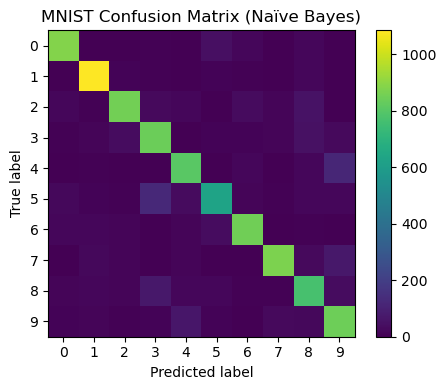

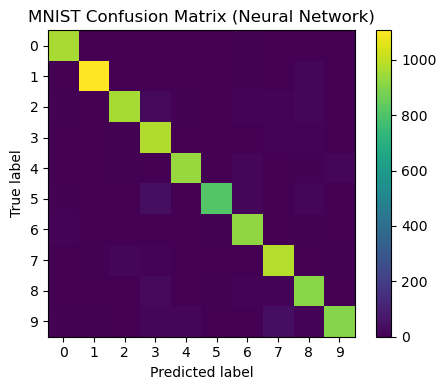

In [6]:
# Confusion matrix for Naïve Bayes
cm_nb = confusion_matrix(y_test_nb, y_test_nb_pred)

# Confusion matrix for NN
nn_test_pred_labels = nn_test_probs.argmax(axis=1)
cm_nn = confusion_matrix(nn_test_labels, nn_test_pred_labels)

def plot_confusion_matrix(cm, title, filename):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    fig.savefig(filename, dpi=150)
    plt.show()

plot_confusion_matrix(cm_nb, "MNIST Confusion Matrix (Naïve Bayes)", "figs/mnist_confusion_nb.png")
plot_confusion_matrix(cm_nn, "MNIST Confusion Matrix (Neural Network)", "figs/mnist_confusion_nn.png")

## 5. Calibration (Reliability) Curves

A classifier is **well-calibrated** if predicted probabilities match empirical frequencies.
For example, among all test examples where the model’s confidence is about 0.8, roughly 80% should be correctly classified.

We compute a simple **reliability diagram**:

1. For each test example, take the **maximum predicted probability** (model confidence);
2. Bin these confidences into intervals (e.g., 10 bins);
3. For each bin, compute:
   - the average predicted confidence,
   - the empirical accuracy (fraction of correct predictions);
4. Plot empirical accuracy vs average confidence.

A perfectly calibrated model would lie on the diagonal.


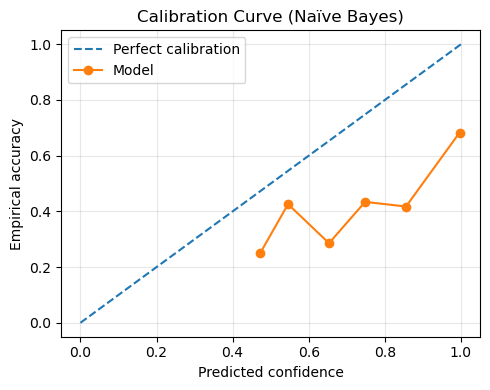

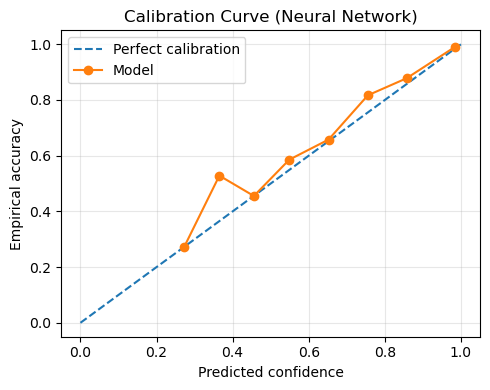

In [7]:
def calibration_curve_from_probs(y_true, prob_matrix, n_bins=10):
    # Compute calibration data for a multi-class classifier using max confidence.
    y_true = np.asarray(y_true)
    prob_matrix = np.asarray(prob_matrix)
    confidences = prob_matrix.max(axis=1)
    predictions = prob_matrix.argmax(axis=1)
    correct = (predictions == y_true).astype(np.float64)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1  # bin index in 0..n_bins-1

    bin_conf = []
    bin_acc = []
    for b in range(n_bins):
        mask = bin_ids == b
        if np.any(mask):
            bin_conf.append(confidences[mask].mean())
            bin_acc.append(correct[mask].mean())
    return np.array(bin_conf), np.array(bin_acc)

def plot_calibration_curve(bin_conf, bin_acc, title, filename):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
    ax.plot(bin_conf, bin_acc, marker="o", label="Model")
    ax.set_xlabel("Predicted confidence")
    ax.set_ylabel("Empirical accuracy")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    fig.savefig(filename, dpi=150)
    plt.show()

# Naïve Bayes calibration
nb_bin_conf, nb_bin_acc = calibration_curve_from_probs(y_test_nb, y_test_nb_proba, n_bins=10)
plot_calibration_curve(nb_bin_conf, nb_bin_acc,
                       "Calibration Curve (Naïve Bayes)",
                       "figs/mnist_calibration_nb.png")

# Neural network calibration
nn_bin_conf, nn_bin_acc = calibration_curve_from_probs(nn_test_labels, nn_test_probs, n_bins=10)
plot_calibration_curve(nn_bin_conf, nn_bin_acc,
                       "Calibration Curve (Neural Network)",
                       "figs/mnist_calibration_nn.png")

## 6. Summary

In this notebook we:

- Implemented a **Naïve Bayes** classifier and a small **neural network** on MNIST;
- Compared their performance via **confusion matrices**;
- Assessed their probabilistic quality via **calibration curves**;
- Saved all figures and prediction tensors in the `figs/` directory for reuse in later chapters
  (e.g., when discussing KL divergence and cross-entropy).

This concrete experiment grounds the abstract formulas
\(\mathbb{P}(C \mid F) \propto \mathbb{P}(C)\mathbb{P}(F\mid C)\)
in practical models that will recur throughout the book.


## 5. KL divergence between Naïve Bayes and Neural Network predictions

In the previous sections we trained two probabilistic classifiers on MNIST:

- a **Naïve Bayes** model producing prediction vectors \(p_{\text{NB}}(C \mid F)\);
- a **neural network** producing prediction vectors \(p_{\text{NN}}(C \mid F)\).

Both outputs are full probability distributions over the 10 digit classes.
A natural way to *compare* these distributions is via the **Kullback–Leibler
(KL) divergence**
\[
D_{\mathrm{KL}}(P \Vert Q)
\;=\;
\sum_{c} P(c)\,\log\frac{P(c)}{Q(c)}.
\]

Here we treat one model as the “reference’’ distribution \(P\) and measure
how different the other model’s predictions \(Q\) are, for each test image.
We will compute:

- \(D_{\mathrm{KL}}(p_{\text{NB}} \Vert p_{\text{NN}})\)  (how costly it is to
  approximate Naïve Bayes by the NN), and
- \(D_{\mathrm{KL}}(p_{\text{NN}} \Vert p_{\text{NB}})\) (the reverse direction).

We will then look at histograms and class-wise averages of these KL values.

Number of test examples: 10000
Mean KL(NB || NN): 0.5588 ± 1.4652
Mean KL(NN || NB): 2.0791 ± 4.4096


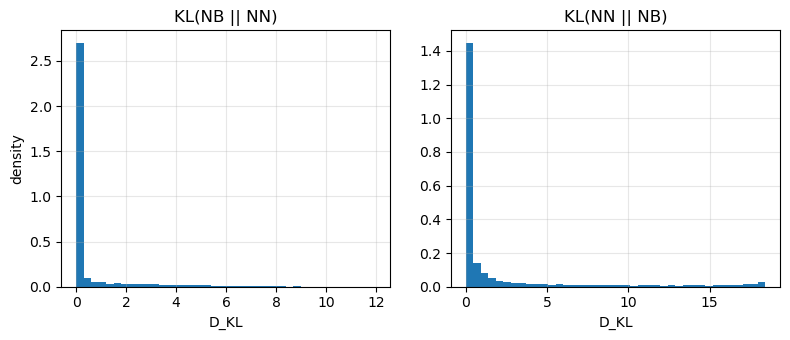

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------------------------
# Load saved probability predictions (created earlier in the notebook)
# -----------------------------------------------------------------------------
nb_probs = np.load("figs/mnist_nb_probs.npy")      # shape: (N_test, 10)
nb_labels = np.load("figs/mnist_nb_labels.npy")    # shape: (N_test,)
nn_probs = np.load("figs/mnist_nn_probs.npy")      # shape: (N_test, 10)
nn_labels = np.load("figs/mnist_nn_labels.npy")    # shape: (N_test,)

assert nb_probs.shape == nn_probs.shape, "Naïve Bayes and NN must have the same number of test examples."
assert np.all(nb_labels == nn_labels), "Label order must match between the two models."

num_classes = nb_probs.shape[1]
eps = 1e-8  # numerical stability


def kl_divergence(p, q, eps=1e-8):
    """Compute D_KL(p || q) for batched distributions p, q of shape (N, K)."""
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * np.log(p / q), axis=1)


# -----------------------------------------------------------------------------
# Per-example KL divergences in both directions
# -----------------------------------------------------------------------------
kl_nb_to_nn = kl_divergence(nb_probs, nn_probs, eps=eps)
kl_nn_to_nb = kl_divergence(nn_probs, nb_probs, eps=eps)

print(f"Number of test examples: {nb_probs.shape[0]}")
print(f"Mean KL(NB || NN): {kl_nb_to_nn.mean():.4f} ± {kl_nb_to_nn.std():.4f}")
print(f"Mean KL(NN || NB): {kl_nn_to_nb.mean():.4f} ± {kl_nn_to_nb.std():.4f}")

# -----------------------------------------------------------------------------
# Histograms of per-example KL divergences
# -----------------------------------------------------------------------------
os.makedirs("figs", exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

axes[0].hist(kl_nb_to_nn, bins=40, density=True)
axes[0].set_title("KL(NB || NN)")
axes[0].set_xlabel("D_KL")
axes[0].set_ylabel("density")
axes[0].grid(alpha=0.3)

axes[1].hist(kl_nn_to_nb, bins=40, density=True)
axes[1].set_title("KL(NN || NB)")
axes[1].set_xlabel("D_KL")
axes[1].grid(alpha=0.3)

fig.tight_layout()
fig.savefig("figs/mnist_kl_hist_nb_vs_nn.png", dpi=150)
plt.show()

### KL statistics and class-wise comparison

KL divergence is **asymmetric**:
\[
D_{\mathrm{KL}}(P \Vert Q) \neq D_{\mathrm{KL}}(Q \Vert P),
\]
so it matters which model we treat as the “true’’ distribution.
The following cell:

- loads the saved probability predictions from both models,
- computes per-example KL divergences in each direction,
- summarizes them via basic statistics,
- and plots **class-wise average KL** to see for which digits the models
  disagree the most.

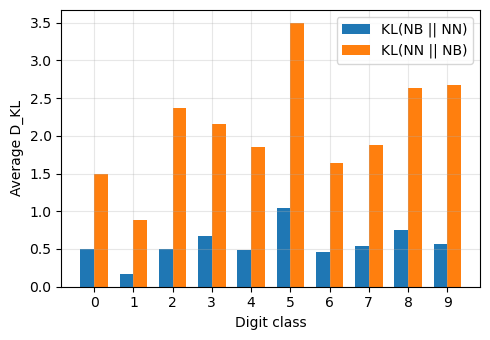

In [9]:
# -----------------------------------------------------------------------------
# Class-wise average KL for each digit
# -----------------------------------------------------------------------------
classes = np.arange(num_classes)

mean_kl_nb_to_nn = []
mean_kl_nn_to_nb = []

for c in classes:
    mask = (nb_labels == c)
    if not np.any(mask):
        mean_kl_nb_to_nn.append(np.nan)
        mean_kl_nn_to_nb.append(np.nan)
        continue
    mean_kl_nb_to_nn.append(kl_nb_to_nn[mask].mean())
    mean_kl_nn_to_nb.append(kl_nn_to_nb[mask].mean())

mean_kl_nb_to_nn = np.array(mean_kl_nb_to_nn)
mean_kl_nn_to_nb = np.array(mean_kl_nn_to_nb)

fig, ax = plt.subplots(figsize=(5, 3.5))
width = 0.35
x = classes

ax.bar(x - width / 2, mean_kl_nb_to_nn, width, label="KL(NB || NN)")
ax.bar(x + width / 2, mean_kl_nn_to_nb, width, label="KL(NN || NB)")
ax.set_xlabel("Digit class")
ax.set_ylabel("Average D_KL")
ax.set_xticks(classes)
ax.legend()
ax.grid(alpha=0.3)

fig.tight_layout()
fig.savefig("figs/mnist_kl_classwise_nb_vs_nn.png", dpi=150)
plt.show()

## Cross-entropy vs. KL divergence: NN vs. Naive Bayes on MNIST

Mean cross-entropy (negative log-likelihood, in nats) on MNIST test set:
  Naïve Bayes : 2.693
  Neural net  : 0.180

Mean cross-entropy expressed in bits (for comparison):
  Naïve Bayes : 3.884 bits
  Neural net  : 0.260 bits


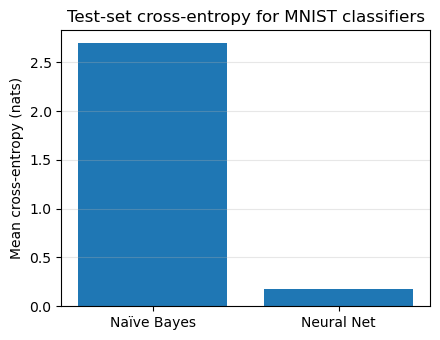

Saved cross-entropy comparison figure to: figs/mnist_ce_bar_nb_vs_nn.png


In [16]:
# -------------------------------------------------------------
# Cross-entropy (negative log-likelihood) for NB vs NN
# -------------------------------------------------------------
# This cell assumes the following are already defined by earlier cells:
#   - y_test          : true labels for the MNIST test set (shape: [N])
#   - proba_nb        : NB predictive probabilities (shape: [N, 10])
#   - proba_mlp       : NN predictive probabilities (shape: [N, 10])
#   - H_nb, H_mlp     : predictive entropies (bits) from previous entropy cell
#
# We compute cross-entropy with respect to the *empirical* (one-hot) labels:
#   CE(model) = - E_data[ log model_prob(true_label) ]
# Note: this is measured in nats because we use natural log.

eps = 1e-12  # for numerical stability
n_test = y_test_nb.shape[0]
idx = np.arange(n_test)

# Cross-entropy per test example (negative log-likelihood)
ce_nb  = -np.log(np.clip(nb_probs[idx, y_test_nb], eps, 1.0))
ce_mlp = -np.log(np.clip(nn_probs[idx, y_test_nb], eps, 1.0))

print("Mean cross-entropy (negative log-likelihood, in nats) on MNIST test set:")
print(f"  Naïve Bayes : {ce_nb.mean():.3f}")
print(f"  Neural net  : {ce_mlp.mean():.3f}")

# For reference, recall the predictive entropies we computed earlier (in bits)
#print("\nMean predictive entropies (in bits) from previous cell:")
#print(f"  Naïve Bayes : {H_nb.mean():.3f}")
#print(f"  Neural net  : {H_mlp.mean():.3f}")

# Optional: convert mean cross-entropy from nats to bits for comparison
log2e = 1.0 / np.log(2.0)
ce_nb_bits  = ce_nb.mean()  * log2e
ce_mlp_bits = ce_mlp.mean() * log2e
print("\nMean cross-entropy expressed in bits (for comparison):")
print(f"  Naïve Bayes : {ce_nb_bits:.3f} bits")
print(f"  Neural net  : {ce_mlp_bits:.3f} bits")

# -------------------------------------------------------------
# Simple bar plot comparing mean cross-entropy of the two models
# -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4.5, 3.5))

ax.bar(["Naïve Bayes", "Neural Net"], [ce_nb.mean(), ce_mlp.mean()])
ax.set_ylabel("Mean cross-entropy (nats)")
ax.set_title("Test-set cross-entropy for MNIST classifiers")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_path = os.path.join("figs", "mnist_ce_bar_nb_vs_nn.png")
plt.savefig(fig_path, dpi=150)
plt.show()

print("Saved cross-entropy comparison figure to:", fig_path)
